## Feature selection

Why would it even be necessary to select features? To some, this idea may seem counterintuitive, but there are at least two important reasons to get rid of unimportant features. The first is clear to every engineer: the more data, the higher the computational complexity. As long as we work with toy datasets, the size of the data is not a problem, but, for real loaded production systems, hundreds of extra features will be quite tangible. The second reason is that some algorithms take noise (non-informative features) as a signal and overfit.

### Statistical approaches

The most obvious candidate for removal is a feature whose value remains unchanged, i.e., it contains no information at all. If we build on this thought, it is reasonable to say that features with low variance are worse than those with high variance. So, one can consider cutting features with variance below a certain threshold.

#### Basado en estadísticos no supervisado

In [3]:
from sklearn.datasets import make_classification
from sklearn.feature_selection import VarianceThreshold

x_data_generated, y_data_generated = make_classification()
x_data_generated.shape

(100, 20)

In [4]:
VarianceThreshold(0.7).fit_transform(x_data_generated).shape

(100, 19)

In [5]:
VarianceThreshold(0.8).fit_transform(x_data_generated).shape

(100, 18)

(100, 14)

#### Basado en estadísticos supervisado

In [6]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score



In [8]:
x_data_kbest = SelectKBest(f_classif, k=5).fit_transform(x_data_generated, y_data_generated)
x_data_varth = VarianceThreshold(.9).fit_transform(x_data_generated)



In [15]:
logit = LogisticRegression(solver='lbfgs', random_state=17)

In [16]:
cross_val_score(logit, x_data_generated, y_data_generated, scoring='neg_log_loss', cv=5).mean()

-0.520835372204659

In [17]:
cross_val_score(logit, x_data_kbest, y_data_generated, scoring='neg_log_loss', cv=5).mean()

-0.4132934139400909

In [18]:
cross_val_score(logit, x_data_varth, y_data_generated, scoring='neg_log_loss', cv=5).mean()

-0.49314537050989565

We can see that our selected features have improved the quality of the classifier. Of course, this example is purely artificial; however, it is worth using for real problems.

### Selection by modeling

Another approach is to use some baseline model for feature evaluation because the model will clearly show the importance of the features. Two types of models are usually used: some “wooden” composition such as [Random Forest](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-5-ensembles-of-algorithms-and-random-forest-8e05246cbba7) or a linear model with Lasso regularization so that it is prone to nullify weights of weak features. The logic is intuitive: if features are clearly useless in a simple model, there is no need to drag them to a more complex one.

#### Supervisado intrinseco

In [19]:
# Synthetic example

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

x_data_generated, y_data_generated = make_classification()

rf = RandomForestClassifier(n_estimators=10, random_state=17)
pipe = make_pipeline(SelectFromModel(estimator=rf), logit)

print(cross_val_score(logit, x_data_generated, y_data_generated, 
                      scoring='neg_log_loss', cv=5).mean())
print(cross_val_score(rf, x_data_generated, y_data_generated, 
                      scoring='neg_log_loss', cv=5).mean())
print(cross_val_score(pipe, x_data_generated, y_data_generated, 
                      scoring='neg_log_loss', cv=5).mean())

-0.6428217079501947
-0.3834068336663474
-0.4753558193871689


We must not forget that this is not a silver bullet again - it can make the performance worse.

In [20]:
from sklearn.preprocessing import StandardScaler

#x_data, y_data = get_data() 
x_data = x_data_generated
y_data = y_data_generated

pipe1 = make_pipeline(StandardScaler(), 
                      SelectFromModel(estimator=rf), logit)

pipe2 = make_pipeline(StandardScaler(), logit)

print('LR + selection: ', cross_val_score(pipe1, x_data, y_data, 
                                          scoring='neg_log_loss', cv=5).mean())
print('LR: ', cross_val_score(pipe2, x_data, y_data, 
                              scoring='neg_log_loss', cv=5).mean())
print('RF: ', cross_val_score(rf, x_data, y_data, 
                              scoring='neg_log_loss', cv=5).mean())

LR + selection:  -0.47553646526803633
LR:  -0.6434309950847746
RF:  -0.3834068336663474


#### Supervisado wrapper

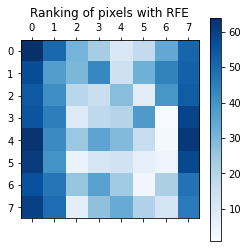

In [21]:
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

# Load the digits dataset
digits = load_digits()
X = digits.images.reshape((len(digits.images), -1))
y = digits.target

# Create the RFE object and rank each pixel
svc = SVC(kernel="linear", C=1)
rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
rfe.fit(X, y)
ranking = rfe.ranking_.reshape(digits.images[0].shape)

# Plot pixel ranking
plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Ranking of pixels with RFE")
plt.show()

In [22]:
svc = SVC(kernel="linear", C=1)
rfe = RFE(estimator=svc, n_features_to_select=10, step=1)
rfe.fit_transform(X, y)

array([[ 9., 11., 12., ...,  7., 12.,  6.],
       [13.,  6., 15., ...,  0.,  6.,  0.],
       [15., 16.,  1., ...,  0., 11.,  0.],
       ...,
       [15., 16.,  8., ...,  0., 16.,  2.],
       [ 7., 16., 16., ...,  2., 16.,  5.],
       [ 8., 15.,  5., ...,  6., 16.,  8.]])